We will define strategies and do backtests for all selected pairs for '1D' & '1H' resolutions.
A summary pdf report will be printed in the end.

In [1467]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn
import dataframe_image as dfi
import math

# define report path
Path("report").mkdir(parents=True, exist_ok=True)

### SETUP

In [1468]:
resolution_list = ['1D','1H']

# report_heading = "Utilities 1Y"  # change for the report heading
report_heading = "UTILITIES 1Y"  # change for the report heading

pos_value = 7500 # x2 for pair buy & sell
mar_req = 0.3 # margin requirement
cash_req = mar_req * pos_value * 2 # required cash
avg_slip = 0.001 # per order per position value
avg_commission = 0.007 # per contract

avg_fin_cost_dic = {'1D':(0.07/365),'1H':(0.07/365/7)} # per borrowed cash per day&hour

### GET PAIR INFORMATION

In [1469]:
with open('pairs_final.pkl', 'rb') as f:
    pairs_dic = pickle.load(f)
pairs_dic

{('CMS', 'DUK'): 1.6,
 ('CNP', 'VST'): 0.78,
 ('OGE', 'XEL'): 1.79,
 ('AEP', 'VST'): 0.25,
 ('ED', 'VST'): 0.25,
 ('AEP', 'CNP'): 0.32}

In [1470]:
with open('pairs_dropped.pkl', 'rb') as f:
    drop_dic = pickle.load(f)
drop_dic

{('AEE', 'DUK'): 1.17, ('AEP', 'OGE'): 0.41}

### DEFINE STRATEGIES

In [1471]:
# buy and sell at upper and lower bollinger band, exit at sma
def exit_sma(data, lower_bb, upper_bb, sma_20, _):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = []
    signal = 0
      
    position = [0] * len(data)
      
    for i in range(len(data)):
        # define band crossings
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if position[i-1] == 0:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if position[i-1] == 0:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        # define sma crossings
        elif data[i - 1] > sma_20[i - 1] and data[i] < sma_20[i]:
            if position[i-1] != 0:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 0
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < sma_20[i - 1] and data[i] > sma_20[i]:
            if position[i-1] != 0:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = 0
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            position[i] = position[i-1]

    return buy_price, sell_price, bb_signal, position


# buy and sell at upper and lower bollinger band, keep position, no exit
def no_exit(data, lower_bb, upper_bb, *_):

    buy_price = []
    sell_price = []
    bb_signal = []
    position = []
    signal = 0
           
    position = [0] * len(data)
    
    for i in range(len(data)):
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            position[i] = position[i-1]

    return buy_price, sell_price, bb_signal, position


# buy and sell at upper and lower bollinger band, exit at sma, no exit if moving towards n days-sma
def skp_sma(data, lower_bb, upper_bb, sma_20, sma_nd):
    buy_price = []
    sell_price = []
    bb_signal = []
    position = []
    signal = 0
      
    position = [0] * len(data)
      
    for i in range(len(data)):
        # define band crossings
        if data[i - 1] > lower_bb[i - 1] and data[i] < lower_bb[i]:
            if position[i-1] != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
                position[i] = 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
        elif data[i - 1] < upper_bb[i - 1] and data[i] > upper_bb[i]:
            if position[i-1] != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
                position[i] = -1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        # define sma crossings
        elif data[i - 1] > sma_20[i - 1] and data[i] < sma_20[i]:
            if data[i] < sma_nd[i]: # check 20d-sma
                if position[i-1] == -1:
                    buy_price.append(data[i])
                    sell_price.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                    position[i] = 0
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    bb_signal.append(0)
                    position[i] = position[i-1]
                    
            else: # moving towards 20d-sma               
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]
                
                
        elif data[i - 1] < sma_20[i - 1] and data[i] > sma_20[i]:
            if data[i] > sma_nd[i]: # check 20d-sma
                if position[i-1] == 1:
                    buy_price.append(np.nan)
                    sell_price.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                    position[i] = 0
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    bb_signal.append(0)
                    position[i] = position[i-1]
                    
            else: # moving towards 20d-sma               
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
                position[i] = position[i-1]

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            position[i] = position[i-1]

    return buy_price, sell_price, bb_signal, position

### DEFINE SMA & BOLLINGER FUNCTIONS

In [1472]:
def sma(values, n):
    return pd.Series(values).rolling(n).mean()

def bb(data, sma, sd=2.0, n=20):
    std = data.rolling(n).std(ddof=1) # default ddof=1, sample standard deviation, divide by (n-1)
    bb_up = sma + std * sd
    bb_low = sma - std * sd
    return bb_up, bb_low

### CALCULATE STRATEGY RETURNS

Define function

In [1473]:
def calculate_returns(data_dic, str_list, b=2):  # b is 1.0, 1.5, 2.0, 2.5 or 3 std

    # list of strategies to apply
    strategy_list = str_list

    # create a dataframe to fill with strategy return values
    df = pd.DataFrame.from_dict(data_dic, orient="index")
    returns_df = df.iloc[:, 1:]  # drop the first column
    returns_with_costs_df = df.iloc[:, 1:]  # drop the first column

    for res in resolution_list:

        for st in range(len(strategy_list)):
            apply_strategy = globals()[strategy_list[st]]

            returns_list = []
            costs_list = []

            for key in data_dic:
                ticker1 = key[0]
                ticker2 = key[1]
                hedge = data_dic[key]
                # print(f"EQUATION: {ticker2}={hedge}*{ticker1}")

                # read data from csv
                alltickersfile = "data/tickers_" + res + ".csv"
                df = pd.read_csv(alltickersfile)
                df_sorted = df.set_index(["ticker", "time"]).sort_index()  # set indexes
                df1 = df_sorted.xs(ticker1)  # the first ticker
                df2 = df_sorted.xs(ticker2)  # the second ticker

                # calculate spread
                df1_1 = hedge * df1
                df_spread = df2.subtract(df1_1).round(5)

                # add sma & bollinger bands
                df_spread["sma_20"] = sma(df_spread.Close, 20)
                
                if res == '1D':                 
                    df_spread['sma_50d']=SMA(df_spread.Close, 50) # add 50d sma for 1D resolution
                
                else:
                    df_spread['sma_20d']=SMA(df_spread.Close, 20*7) # add 20d sma for 1H resolution
                
                for i in range(2, 7):
                    step = 0.5
                    b_band = round(step*i,1)
                    (
                        df_spread["bb_up_" + str(b_band)],
                        df_spread["bb_low_" + str(b_band)],
                    ) = bb(df_spread["Close"], df_spread["sma_20"], b_band, 20)

                df_spread_bb = df_spread.copy()
                df_spread_bb = df_spread_bb.dropna()

                # apply strategy & positions
                
                if res == '1D':               
                    buy_price, sell_price, signal, position = apply_strategy(
                        df_spread_bb["Close"],
                        df_spread_bb["bb_low_" + str(round(b,1))],
                        df_spread_bb["bb_up_" + str(round(b,1))],
                        df_spread_bb["sma_20"],
                        df_spread_bb["sma_50d"]
                    )
                else:                       
                    buy_price, sell_price, signal, position = apply_strategy(
                        df_spread_bb["Close"],
                        df_spread_bb["bb_low_" + str(round(b,1))],
                        df_spread_bb["bb_up_" + str(round(b,1))],
                        df_spread_bb["sma_20"],
                        df_spread_bb["sma_20d"]
                    )
                        
                signal_df = (
                    pd.DataFrame(signal)
                    .rename(columns={0: "signal"})
                    .set_index(df_spread_bb.index)
                )
                position_df = (
                    pd.DataFrame(position)
                    .rename(columns={0: "bb_position"})
                    .set_index(df_spread_bb.index)
                )

                # calculate price difference per bar
                df_spread_bb_ret = pd.DataFrame(np.diff(df_spread_bb["Close"])).rename(
                    columns={0: "returns"}
                )

                # calculate return per bar
                bb_strategy_ret = []
                for i in range(len(df_spread_bb_ret)):
                    try:
                        returns = (
                            df_spread_bb_ret["returns"][i]
                            * position_df["bb_position"][i]
                        )
                        bb_strategy_ret.append(returns)
                    except:
                        pass

                bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(
                    columns={0: "bb_returns"}
                )

                # calculate investment return
                contract_price = round(df2.iloc[-1,df2.columns.get_loc('Close')],0) # get the latest price
                number_of_stocks = math.floor(pos_value / contract_price)
                bb_investment_ret = []

                for i in range(len(bb_strategy_ret_df["bb_returns"])):
                    returns = number_of_stocks * bb_strategy_ret_df["bb_returns"][i]
                    bb_investment_ret.append(returns)

                bb_investment_ret_df = pd.DataFrame(bb_investment_ret).rename(
                    columns={0: "investment_returns"}
                )
                total_investment_ret = round(
                    sum(bb_investment_ret_df["investment_returns"]), 2
                )
                profit_percentage = math.floor((total_investment_ret / cash_req) * 100)

                returns_list.append(profit_percentage)

                slip = signal_df.signal.abs() * avg_slip * pos_value
                commission = signal_df.signal.abs() * avg_commission * number_of_stocks * 2
                fincost = (
                    position_df.bb_position.abs()
                    * avg_fin_cost_dic[res]
                    * (2 * pos_value - cash_req)
                )

                total_cost = (
                    slip.sum().round(1)
                    + commission.sum().round(1)
                    + fincost.sum().round(1)
                )

                total_investment_ret_cost = (
                    round(sum(bb_investment_ret_df["investment_returns"]), 2)
                    - total_cost
                )
                profit_percentage_cost = math.floor(
                    (total_investment_ret_cost / cash_req) * 100
                )

                costs_list.append(profit_percentage_cost)

            returns_df[res + "_" + strategy_list[st]] = returns_list
            returns_with_costs_df[res + "_" + strategy_list[st]] = costs_list

    return returns_df, returns_with_costs_df

Run and display results

average return - 1D_exit_sma : 35.33%
average return - 1D_no_exit : 39.33%
average return - 1H_exit_sma : 23.17%
average return - 1H_no_exit : 39.0%
average return (costs included) - 1D_exit_sma : 27.83%
average return (costs included) - 1D_no_exit : 29.67%
average return (costs included) - 1H_exit_sma : -8.17%
average return (costs included) - 1H_no_exit : 19.83%


,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('AEP', 'VST')",58,79,44,114
"('CNP', 'VST')",63,77,15,31
"('OGE', 'XEL')",19,28,35,19
"('CMS', 'DUK')",19,17,28,36
"('ED', 'VST')",36,24,6,23
"('AEP', 'CNP')",17,11,11,11
,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('AEP', 'VST')",49,68,10,93
"('CNP', 'VST')",54,67,-21,10
"('OGE', 'XEL')",12,19,7,2


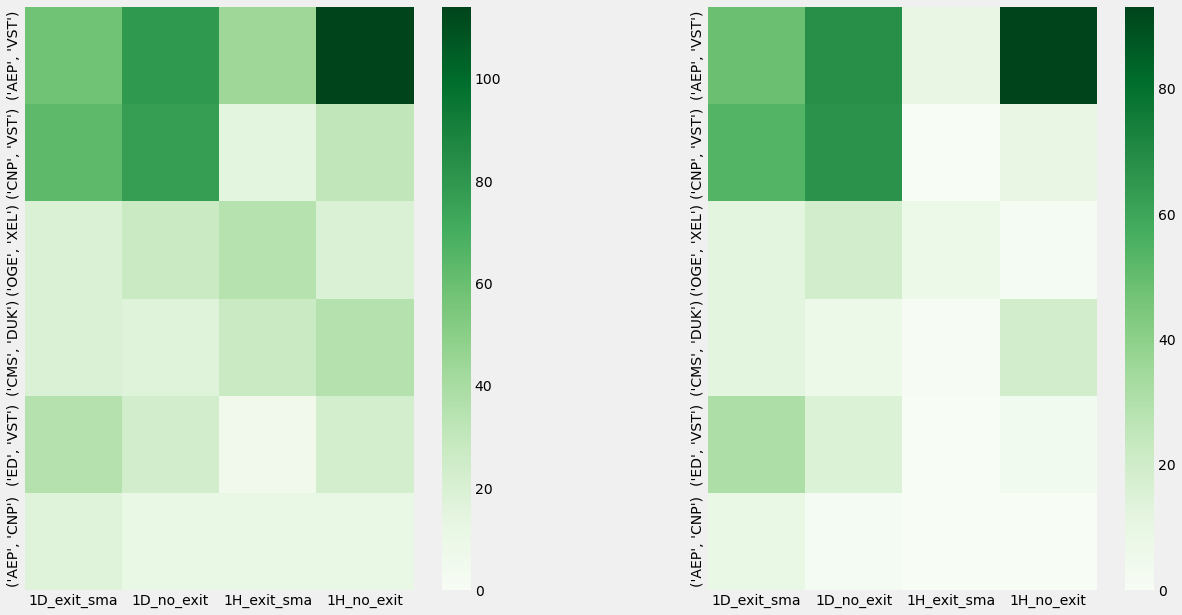

In [1495]:
from IPython.display import display_html 

#strategy_list = ["exit_sma", "no_exit", "skp_sma"]
str_list = ["exit_sma", "no_exit"]

df1_2_0std, df2_2_0std = calculate_returns(pairs_dic, str_list, b=2.0) # b is 1.0, 1.5, 2.0, 2.5 or 3 std

for col in df1_2_0std.columns:
    print(f"average return - {col} : {round(df1_2_0std[col].mean(),2)}%")

for col in df2_2_0std.columns:
    print(f"average return (costs included) - {col} : {round(df2_2_0std[col].mean(),2)}%")
    
df1_sort = df1_2_0std.copy()
df2_sort = df2_2_0std.copy()
df1_sort['mean'] = df1_2_0std.mean(axis=1)
df1_sort = df1_sort.sort_values('mean', ascending=False)
df2_sort['mean'] = df2_2_0std.mean(axis=1)
df2_sort = df2_sort.sort_values('mean', ascending=False)
df1_sort = df1_sort.drop(columns=['mean'])
df2_sort = df2_sort.drop(columns=['mean'])

df1_style = df1_sort.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("2DEV Return%")
df2_style = df2_sort.style.set_table_attributes("style='display:inline'").set_caption(" 2DEV Return% (costs inc.)")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)


fig, (ax1, ax2) = plt.subplots(1,2)
seaborn.heatmap(
    df1_sort,
    xticklabels=df1_sort.columns,
    yticklabels=df1_sort.index,
    cmap="Greens",
    square=True,
    vmin=0,
    ax=ax1
)
seaborn.heatmap(
    df2_sort,
    xticklabels=df2_sort.columns,
    yticklabels=df2_sort.index,
    cmap="Greens",
    square=True,
    vmin=0,
    ax=ax2
)

dpi_set=100
dfi.export(df1_style, 'summary1.png', dpi=dpi_set)
dfi.export(df2_style, 'summary2.png', dpi=dpi_set)
plt.savefig('summary_plot1', dpi=dpi_set, bbox_inches='tight', pad_inches=0)


average return - 1D_exit_sma : 21.5%
average return - 1D_no_exit : 40.0%
average return - 1H_exit_sma : 20.5%
average return - 1H_no_exit : 28.5%
average return (costs included) - 1D_exit_sma : 14.5%
average return (costs included) - 1D_no_exit : 29.0%
average return (costs included) - 1H_exit_sma : -8.5%
average return (costs included) - 1H_no_exit : 9.5%


,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('AEP', 'OGE')",26,59,30,34
"('AEE', 'DUK')",17,21,11,23
,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
"('AEP', 'OGE')",17,47,-1,14
"('AEE', 'DUK')",12,11,-16,5


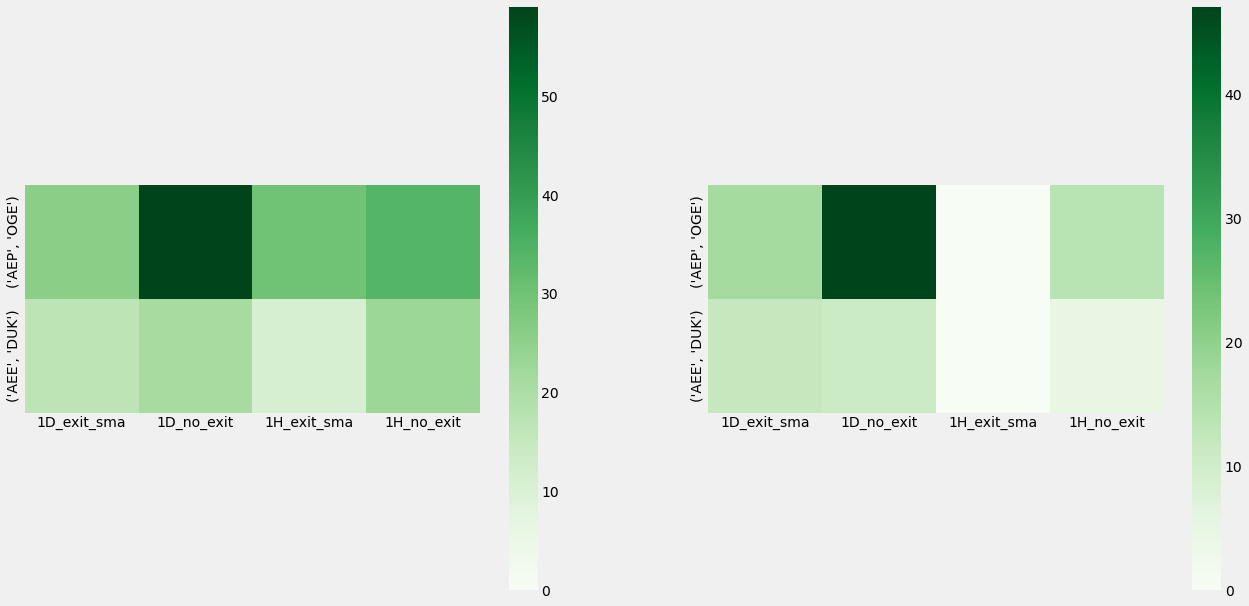

In [1475]:
if bool(drop_dic):
    
    df1_drop, df2_drop = calculate_returns(drop_dic, str_list, b=2.0) # b is 1,2 or 3 std

    for col in df1_drop.columns:
        print(f"average return - {col} : {round(df1_drop[col].mean(),2)}%")

    for col in df2_drop.columns:
        print(f"average return (costs included) - {col} : {round(df2_drop[col].mean(),2)}%")

    df1_drop_sort = df1_drop.copy()
    df2_drop_sort = df2_drop.copy()
    df1_drop_sort['mean'] = df1_drop.mean(axis=1)
    df1_drop_sort = df1_drop_sort.sort_values('mean', ascending=False)
    df2_drop_sort['mean'] = df2_drop.mean(axis=1)
    df2_drop_sort = df2_drop_sort.sort_values('mean', ascending=False)
    df1_drop_sort = df1_drop_sort.drop(columns=['mean'])
    df2_drop_sort = df2_drop_sort.drop(columns=['mean'])

    df1_style_drop = df1_drop_sort.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("Return%")
    df2_style_drop = df2_drop_sort.style.set_table_attributes("style='display:inline'").set_caption("Return% (costs inc.)")


    display_html(df1_style_drop._repr_html_() + df2_style_drop._repr_html_(), raw=True)

    fig, (ax1, ax2) = plt.subplots(1,2)
    seaborn.heatmap(
        df1_drop_sort,
        xticklabels=df1_drop_sort.columns,
        yticklabels=df1_drop_sort.index,
        cmap="Greens",
        square=True,
        vmin=0,
        ax=ax1
    )
    seaborn.heatmap(
        df2_drop_sort,
        xticklabels=df2_drop_sort.columns,
        yticklabels=df2_drop_sort.index,
        cmap="Greens",
        square=True,
        vmin=0,
        ax=ax2
    )

    # dpi_set=100
    # dfi.export(df1_style_drop, 'summary1_drop.png', dpi=dpi_set)
    # dfi.export(df2_style_drop, 'summary2_drop.png', dpi=dpi_set)
    # plt.savefig('summary_plot1_drop', dpi=dpi_set, bbox_inches='tight', pad_inches=0)

### EXERCISE : Calculate all strategies from 1 std to 3 std dev

Calculate returns

In [1491]:
str_list = ["exit_sma", "no_exit", "skp_sma"]

df1_1_0std, df2_1_0std = calculate_returns(pairs_dic,str_list,b=1.0)
df1_1_5std, df2_1_5std = calculate_returns(pairs_dic,str_list,b=1.5)
df1_2_0std, df2_2_0std = calculate_returns(pairs_dic,str_list,b=2.0)
df1_2_5std, df2_2_5std = calculate_returns(pairs_dic,str_list,b=2.5)
df1_3_0std, df2_3_0std = calculate_returns(pairs_dic,str_list,b=3.0)

df2_1_0std['bb'] = 1.0
df2_1_5std['bb'] = 1.5
df2_2_0std['bb'] = 2.0
df2_2_5std['bb'] = 2.5
df2_3_0std['bb'] = 3.0
df2_all = pd.concat([df2_1_0std,df2_1_5std,df2_2_0std,df2_2_5std,df2_3_0std])

df2_all.head()

,1D_exit_sma,1D_no_exit,1D_skp_sma,1H_exit_sma,1H_no_exit,1H_skp_sma,bb
"(CMS, DUK)",14,-3,13,-20,17,4,1.00
"(CNP, VST)",46,54,56,-69,-2,-1,1.00
"(OGE, XEL)",3,-9,5,-21,33,28,1.00
"(AEP, VST)",37,59,48,-10,-6,-23,1.00
"(ED, VST)",105,134,117,-81,-30,-44,1.00


Group by bb band

In [1492]:
df2_all1 = df2_all.copy()
df2_all1 = df2_all1.reset_index()
df2_all1 = df2_all1.rename(columns={"index": "pair"})
df2_all1 = df2_all1.set_index(['bb','pair']).sort_index()
df2_all1.tail()

1D_exit_sma  1D_no_exit  1D_skp_sma  1H_exit_sma  1H_no_exit  \
bb   pair                                                                       
3.00 (AEP, VST)            8          -7           2           22          95   
     (CMS, DUK)            0           0           0            8          10   
     (CNP, VST)            6          -5           6            3           1   
     (ED, VST)             7          -1           4            7           7   
     (OGE, XEL)           -1           3           2           -4          -6   

                 1H_skp_sma  
bb   pair                    
3.00 (AEP, VST)          56  
     (CMS, DUK)          20  
     (CNP, VST)          26  
     (ED, VST)           17  
     (OGE, XEL)           9

Slice & Add level by std. dev

In [1493]:
df2_list =[]
df2_sort =[]
df2_sort_leveled =[]

for i in range(2,7):
    step = 0.5
    b_band = round(step*i,1)
    df2_list.append(df2_all1.xs((b_band,))) 
    
for i in range(len(df2_list)):
    df2_sort.append(df2_list[i])
    df2_sort[i]['mean'] = df2_list[i].mean(axis=1).round(1)
    df2_sort[i] = df2_sort[i].sort_values('mean', ascending=False)
    mean_cols = df2_list[i].mean(axis=0).round(1)
    df2_sort[i].loc["avg"] = mean_cols
    df2_nomean= df2_sort[i].loc[ : , df2_sort[i].columns != 'mean']
    df2_nomean = df2_nomean.sort_values('avg', axis=1, ascending=False)
    df2_nomean['mean'] = df2_sort[i]['mean']
    df2_sort[i] = df2_nomean
    df2_sort_leveled.append(pd.concat([df2_sort[i]], keys=[str(i/2+1) + ' DEV RETURN%'], axis=1))


Show dataframes

In [1494]:
df2_std1_0leveled = df2_sort_leveled[0]
df2_std1_5leveled = df2_sort_leveled[1]
df2_std2_0leveled = df2_sort_leveled[2]
df2_std2_5leveled = df2_sort_leveled[3]
df2_std3_0leveled = df2_sort_leveled[4]


std1_0style = df2_std1_0leveled.style.set_table_attributes("style='display:inline; margin-right:20px;'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std1_5style = df2_std1_5leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std2_0style = df2_std2_0leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std2_5style = df2_std2_5leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

std3_0style = df2_std3_0leveled.style.set_table_attributes("style='display:inline'")\
        .highlight_max(color = 'lightgreen', axis = 0)\
        .highlight_min(color = 'lightsalmon', axis = 0)\
        .format('{:,}')

display_html(std1_0style._repr_html_() + std1_5style._repr_html_() + std2_0style._repr_html_() + std2_5style._repr_html_() + std3_0style._repr_html_(), raw=True)

1.0 DEV RETURN% 
 
 
   
 1D_skp_sma 
 1D_no_exit 
 1D_exit_sma 
 1H_no_exit 
 1H_skp_sma 
 1H_exit_sma 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('ED', 'VST') 
 117.0 
 134.0 
 105.0 
 -30.0 
 -44.0 
 -81.0 
 33.5 
 
 
 ('AEP', 'VST') 
 48.0 
 59.0 
 37.0 
 -6.0 
 -23.0 
 -10.0 
 17.5 
 
 
 ('CNP', 'VST') 
 56.0 
 54.0 
 46.0 
 -2.0 
 -1.0 
 -69.0 
 14.0 
 
 
 ('OGE', 'XEL') 
 5.0 
 -9.0 
 3.0 
 33.0 
 28.0 
 -21.0 
 6.5 
 
 
 ('CMS', 'DUK') 
 13.0 
 -3.0 
 14.0 
 17.0 
 4.0 
 -20.0 
 4.2 
 
 
 ('AEP', 'CNP') 
 22.0 
 10.0 
 6.0 
 0.0 
 -11.0 
 -34.0 
 -1.2 
 
 
 avg 
 43.5 
 40.8 
 35.2 
 2.0 
 -7.8 
 -39.2 
 12.4 
 
 
 

 
 
 
   
 1.5 DEV RETURN% 
 
 
   
 1D_skp_sma 
 1D_no_exit 
 1D_exit_sma 
 1H_no_exit 
 1H_skp_sma 
 1H_exit_sma 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('ED', 'VST') 
 111.0 
 106.0 
 86.0 
 -27.0 
 -24.0 
 -29.0 
 37.2 
 
 
 ('AEP', 'VST') 
 66.0 
 75.0 
 67.0 
 18.0 
 -5.0 
 -23.0 
 33.0 
 
 
 ('CNP', 'VST') 
 54.0 
 31.0 
 52.0 
 13.0 
 14.0 
 -36.0 
 21.3 
 
 
 ('CMS', 'DUK') 
 31.0 
 16.0 
 23.0 
 1.0 
 2.0 
 -11.0 
 10.3 
 
 
 ('OGE', 'XEL') 
 10.0 
 0.0 
 1.0 
 10.0 
 27.0 
 -3.0 
 7.5 
 
 
 ('AEP', 'CNP') 
 22.0 
 26.0 
 9.0 
 -4.0 
 -8.0 
 -27.0 
 3.0 
 
 
 avg 
 49.0 
 42.3 
 39.7 
 1.8 
 1.0 
 -21.5 
 18.7 
 
 
 

 
 
 
   
 2.0 DEV RETURN% 
 
 
   
 1D_skp_sma 
 1D_no_exit 
 1D_exit_sma 
 1H_skp_sma 
 1H_no_exit 
 1H_exit_sma 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('AEP', 'VST') 
 56.0 
 68.0 
 49.0 
 72.0 
 93.0 
 10.0 
 58.0 
 
 
 ('CNP', 'VST') 
 68.0 
 67.0 
 54.0 
 20.0 
 10.0 
 -21.0 
 33.0 
 
 
 ('ED', 'VST') 
 15.0 
 15.0 
 31.0 
 37.0 
 4.0 
 -26.0 
 12.7 
 
 
 ('OGE', 'XEL') 
 17.0 
 19.0 
 12.0 
 16.0 
 2.0 
 7.0 
 12.2 
 
 
 ('CMS', 'DUK') 
 11.0 
 7.0 
 12.0 
 19.0 
 19.0 
 1.0 
 11.5 
 
 
 ('AEP', 'CNP') 
 14.0 
 2.0 
 9.0 
 -1.0 
 -9.0 
 -20.0 
 -0.8 
 
 
 avg 
 30.2 
 29.7 
 27.8 
 27.2 
 19.8 
 -8.2 
 21.1 
 
 
 

 
 
 
   
 2.5 DEV RETURN% 
 
 
   
 1H_skp_sma 
 1H_no_exit 
 1H_exit_sma 
 1D_exit_sma 
 1D_skp_sma 
 1D_no_exit 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('AEP', 'VST') 
 77.0 
 85.0 
 30.0 
 0.0 
 -2.0 
 -10.0 
 30.0 
 
 
 ('OGE', 'XEL') 
 24.0 
 1.0 
 9.0 
 12.0 
 15.0 
 30.0 
 15.2 
 
 
 ('CMS', 'DUK') 
 25.0 
 24.0 
 11.0 
 1.0 
 2.0 
 -3.0 
 10.0 
 
 
 ('AEP', 'CNP') 
 16.0 
 0.0 
 -11.0 
 11.0 
 12.0 
 18.0 
 7.7 
 
 
 ('ED', 'VST') 
 36.0 
 -1.0 
 3.0 
 -1.0 
 -4.0 
 -9.0 
 4.0 
 
 
 ('CNP', 'VST') 
 22.0 
 -32.0 
 11.0 
 6.0 
 6.0 
 -5.0 
 1.3 
 
 
 avg 
 33.3 
 12.8 
 8.8 
 4.8 
 4.8 
 3.5 
 11.4 
 
 
 

 
 
 
   
 3.0 DEV RETURN% 
 
 
   
 1H_skp_sma 
 1H_no_exit 
 1H_exit_sma 
 1D_exit_sma 
 1D_skp_sma 
 1D_no_exit 
 mean 
 
 
 pair 
   
   
   
   
   
   
   
 
 
 
 
 ('AEP', 'VST') 
 56.0 
 95.0 
 22.0 
 8.0 
 2.0 
 -7.0 
 29.3 
 
 
 ('ED', 'VST') 
 17.0 
 7.0 
 7.0 
 7.0 
 4.0 
 -1.0 
 6.8 
 
 
 ('CMS', 'DUK') 
 20.0 
 10.0 
 8.0 
 0.0 
 0.0 
 0.0 
 6.3 
 
 
 ('CNP', 'VST') 
 26.0 
 1.0 
 3.0 
 6.0 
 6.0 
 -5.0 
 6.2 
 
 
 ('AEP', 'CNP') 
 6.0 
 2.0 
 3.0 
 0.0 
 0.0 
 0.0 
 1.8 
 
 
 ('OGE', 'XEL') 
 9.0 
 -6.0 
 -4.0 
 -1.0 
 2.0 
 3.0 
 0.5 
 
 
 avg 
 22.3 
 18.2 
 6.5 
 3.3 
 2.3 
 -1.7 
 8.5

In [1480]:
dpi_set=100
dfi.export(std1_0style, 'table1.png', dpi=dpi_set)
dfi.export(std1_5style, 'table2.png', dpi=dpi_set)
dfi.export(std2_0style, 'table3.png', dpi=dpi_set)
dfi.export(std2_5style, 'table4.png', dpi=dpi_set)
dfi.export(std3_0style, 'table5.png', dpi=dpi_set)
plt.savefig('summary_plot1', dpi=dpi_set, bbox_inches='tight', pad_inches=0)

<Figure size 1440x720 with 0 Axes>

Get col. values

In [1481]:
df1_leveled[('3 STD', '1D_exit_sma')]

pair
(AEP, CNP)     0
(AEP, VST)    11
(CMS, DUK)     0
(CNP, VST)     8
(ED, VST)      9
(NRG, VST)    14
(SO, VST)     11
(VST, WEC)     3
Name: (3 STD, 1D_exit_sma), dtype: int64

Get index values

In [1482]:
df1_all1.xs((1,('AEP', 'CNP')))

1D_exit_sma    15
1D_no_exit     24
1H_exit_sma    74
1H_no_exit     68
Name: (1, (AEP, CNP)), dtype: int64

Average returns by selected standard deviation

In [1483]:
df1_all1.groupby(["bb"]).mean()

,1D_exit_sma,1D_no_exit,1H_exit_sma,1H_no_exit
bb,,,,
1,63.38,87.88,82.75,127.38
2,43.88,44.88,91.75,76.50
3,7.00,6.25,50.12,25.12


Mean,Max,Min by selected standard deviation

In [1484]:
df1_all1.groupby(["bb"]).agg({"1H_no_exit": ["mean", "max", "min"]})

1H_no_exit         
         mean  max min
bb                    
1      127.38  205   8
2       76.50  182 -73
3       25.12   68 -38

### EXERCISE : PRINT TO PDF

In [1496]:
import fpdf
from fpdf import FPDF
import time
from PIL import Image

#find the table size
im = Image.open("summary1.png")

#image size
width_table = im.size[0]*(25.4/dpi_set) #converted to approx mm
height_table = im.size[1]*(25.4/dpi_set) #converted to approx mm

def write_big(pdf, words):
    
    # Set text colour, font size, and font type
    pdf.set_text_color(r=0,g=0,b=0)
    pdf.set_font('Helvetica', '', 12)
    
    pdf.write(5, words)
    
def write_small(pdf, words):
    
    # Set text colour, font size, and font type
    pdf.set_text_color(r=0,g=0,b=0)
    pdf.set_font('Helvetica', 'b', 8)
    
    pdf.write(5, words)

title = "Summary Report (" +report_heading+ ")"
# A4 (210 by 297 mm)
WIDTH = 210
HEIGHT = 297

# Create PDF
pdf = FPDF() 

# Add Page
pdf.add_page()

# Add main title
pdf.set_font('Helvetica', 'b', 20)  
pdf.write(5, title)
pdf.ln(8)

# Add date of report
pdf.set_font('Helvetica', '', 14)
pdf.set_text_color(r=128,g=128,b=128)
today = time.strftime("%d/%m/%Y")
pdf.write(4, f'{today}')
pdf.ln(10)
    
# Add explanation
write_big(pdf, "Selected Pairs:")
pdf.ln(5)

# Add pairs
for ind in df2_2_0std.index:
    ticker1 = ind[0]
    ticker2 = ind[1]
    hedge = pairs_dic[ind]
    pairtext = f"| {ticker2}={hedge}*{ticker1} "
    write_small(pdf, pairtext)
write_small(pdf, "|")
pdf.ln(5)
write_small(pdf, "Average Returns:")
for col in df2_2_0std.columns:
    returntext = f" {col} : {round(df2_2_0std[col].mean(),2)}% "
    write_small(pdf, returntext)
# Add tables
pos_y = 50
pdf.image("summary1.png", x=5, y=pos_y, w=WIDTH/2-10)
pdf.image("summary2.png", x=WIDTH/2, y=pos_y, w=WIDTH/2-10)

# Add the generated visualisations to the PDF
plot_y = pos_y + int(height_table)-5
pdf.image("summary_plot1.png", x=8, y=plot_y, w=190)

# Add Another Page
#pdf.add_page(orientation="landscape")
pdf.add_page()

# Add main title
pdf.set_font('Helvetica', 'b', 14)  
pdf.write(5, "Detailed Tables:")
pdf.ln(8)

# Add tables landscape 2 x 3
# pos_y = 20
# pos_x = 4
# pdf.image("table1.png", x=pos_x, y=pos_y, w=HEIGHT/3.2)
# pdf.image("table2.png", x=pos_x+HEIGHT/3, y=pos_y, w=HEIGHT/3.2)
# pdf.image("table3.png", x=pos_x+2*(HEIGHT/3), y=pos_y, w=HEIGHT/3.2)
# pos_y = pos_y + WIDTH/2 -len(df2_2_0std.index)
# pdf.image("table4.png", x=pos_x, y=pos_y, w=HEIGHT/3.2)
# pdf.image("table5.png", x=pos_x+HEIGHT/3, y=pos_y, w=HEIGHT/3.2)

# Add tables 1 x 1
pdf.ln(2)
pdf.image("table1.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table2.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table3.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table4.png", w=WIDTH/1.4)
pdf.ln(4)
pdf.image("table5.png", w=WIDTH/1.4)


# Generate the PDF
today = time.strftime("%d_%m_%Y")
filename = f"report/summary_{today}_{report_heading}.pdf"
pdf.output(filename, 'F')

''